# Speech Emotion Recognition - SER

**Definition**

Speech Emotion Recognition or SER is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

**Why we need it?**

Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

**For example**
1. SER is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services
2. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

# Machine Learning Pipeline
<img src="https://www.altexsoft.com/media/2020/05/word-image-43.png" alt="image.png" width="1000" height="300">

In [3]:
from typing import List, Tuple, Dict, Optional
import pandas as pd
import numpy as np
import json 
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from itertools import combinations
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split # type: ignore
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, PrecisionRecallDisplay, precision_recall_curve, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve # type: ignore
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import time
import concurrent.futures
import joblib

# librosa = Python library for analyzing audio and music. It can be used to extract the audio features from the audio files
import librosa # type: ignore
import librosa.display # type: ignore


# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### **<u>Step 1:</u>** Data Collection
**Datasets used in this project**

Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)  
Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)  
Surrey Audio-Visual Expressed Emotion (Savee)  
Toronto emotional speech set (Tess)  

In [4]:
# CONSTANTS
NUMBER_OF_AUG = 3

# PATHS
Ravdess = "data/ravdess/audio_speech_actors_01-24/"
Crema = "data/cremad/AudioWAV/"
Tess = "data/tess/TESS/"
Savee = "data/savee/ALL/"
data_path = 'data/data_path.csv'
train_features_path = 'data/train_features.csv'
test_features_path = 'data/test_features.csv'
feature_groups_path = 'data/feature_groups.json'
clf_paths = {'Random Forest': 'data/clfs/rf_clf.pkl',
             'Linear kernel SVM': 'data/clfs/svm_clf.pkl',
             'Radial Basis Function (RBF) kernel SVM': 'data/clfs/rbf_svm.pkl',
             'Gradient Boosting': 'data/clfs/gbm_clf.pkl'}
permu_im_path = 'data/permut_imp/random_forest_pi.pkl'

# DATASET
feature_groups ={}
mel_size = 120
chroma_size = 12
mfcc_size = 20
spectral_contrast_size = 7
ahsm_size = 6
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']

# FEATURES
# ZCR = zero crossing rate keys (1X1)
zcr_keys = ['zcr']
# Chroma features keys (12X1)
chroma_keys = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
# MFCC = Mel-frequency cepstral coefficients keys (12X1)
mfcc_size = feature_groups.get('MFCC') or mfcc_size
mel_keys = ['mel_c{}'.format(i) for i in range(1, mfcc_size+1)]
# RMS = Root Mean Square Value. (1X1)
rms_keys = ['rms']
# mel coefficients - PSD keys (120X1)
mel_size = feature_groups.get('PSD') or mel_size
psd_keys = ['psd{}'.format(i) for i in range(1, mel_size+1)]
# AHSM keys (6X1)
ahsm_keys = ['AHSM1', 'AHSM2', 'AHSM3', 'AHSM4', 'AHSM5', 'AHSM6']
# Spectral Contrast feature 1D array (7X1)
contrast_keys = ['contrast{}'.format(i) for i in range(1, spectral_contrast_size+1)]
# Spectral Bandwidth feature 1D array (1X1)
bandwidth_keys = ['bandwidth']
# Spectral Centroid feature 1D array (1X1)
centroid_keys = ['centroid']
# Spectral Rolloff feature 1D array (1X1)
rolloff_keys = ['rolloff']
# Augmentation feature 1D array (1X1)
augmentation_key = ['augmentation']
# Augmentation feature 1D array (1X1)
class_label_key = ['Emotion']

# Add labels to each column
column_labels = zcr_keys + chroma_keys + mel_keys + rms_keys + psd_keys + ahsm_keys + contrast_keys + bandwidth_keys + centroid_keys + rolloff_keys + augmentation_key + class_label_key

# COLORS
group_colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'navy', 'lime', 'teal', 'aqua', 'maroon', 'fuchsia', 'silver', 'gold', 'crimson', 'coral', 'indigo', 'ivory', 'khaki', 'lavender', 'magenta', 'orchid', 'plum', 'salmon', 'sienna', 'tan', 'thistle', 'turquoise', 'violet', 'wheat']
RED = '\033[91m'
GREEN = '\033[92m'
BLUE = '\033[94m'
RESET = '\033[0m'  # Reset color to default
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
ITALIC = '\033[3m'

# FLAGS
Normalized = True

# AUDIO FEATURES
SR = 44100
FRAME_LENGTH = int(0.03 * SR)  # 30 ms
HOP_LENGTH = int(FRAME_LENGTH / 2)  # 50% overlap

# function to select colors for the groups
def select_colors(group_colors, number_of_groups):
    repetitions = number_of_groups // len(group_colors) + 1
    selected_colors = group_colors * repetitions
    return selected_colors[:number_of_groups]

# Example usage:
selected_colors = select_colors(group_colors, 10)
print(selected_colors)


['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'brown', 'pink']


### FUNCTIONS:
**PARSING DATA** - Reads the data and saves it into a panda's DataFrame.  
**READ & WRITE** - Utility functions to deal with reading files writhing into them.  
**PLOTS** - Vissualy portrays time series data, frequency domain data, class labels histogram, confusion matrix, etc.  
**AUGMENTATION** - Explore augmentation: noise, shifting, pitching, stretching.  
**FEATURE EXTRACTION** - Function to extract features from the data,  


In [5]:
#---------------------------------------------------------------------------------------
#---------------------- Parsing Datasets  ----------------------------------------------
#---------------------------------------------------------------------------------------
def parse_ravdess():
    # RAVDESS dataset contains 1440 files: 60 trials per actor x 24 actors = 1440. 
    # Each file was rated 10 times on emotional validity, intensity, and genuineness. 
    # Ratings were provided by 247 individuals who were characteristic of untrained adult research participants from North America. 
    # A further set of 72 participants provided test-retest data. 
    # High levels of emotional validity, interrater reliability, and test-retest intrarater reliability were reported. 
    # Validation data is open to the public, and this database is intended to facilitate the study of emotional speech.

    # The dataset contains 24 professional actors (12 male and 12 female), vocalizing two lexically-matched statements in a neutral North American accent.
    # Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions.
    # 1440 files in total.
    ravdess_directory_list = os.listdir(Ravdess)

    file_emotion = []
    file_path = []
    for dir in ravdess_directory_list:
        # as there are 20 different actors in our previous directory we need to extract files for each actor.
        actor = os.listdir(Ravdess + dir)
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            # third part in each file represents the emotion associated to that file.
            file_emotion.append(int(part[2]))
            file_path.append(Ravdess + dir + '/' + file)
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

    # changing integers to actual emotions.
    Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
    Ravdess_df.head()
    return Ravdess_df

def parse_crema():
    # The dataset contains 7442 files in total.
    # The dataset contains 91 different actors and the recordings are in the form of monologues.
    # The dataset contains 6 different emotions: angry, disgust, fear, happy, neutral, sad.
    crema_directory_list = os.listdir(Crema)

    file_emotion = []
    file_path = []

    for file in crema_directory_list:
        # storing file paths
        file_path.append(Crema + file)
        # storing file emotions
        part=file.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Crema_df = pd.concat([emotion_df, path_df], axis=1)
    Crema_df.head()
    return Crema_df

def parse_tess():
    # The dataset contains 2800 files in total.    
    # The dataset contains 2 different emotions: angry, disgust, fear, happy, neutral, sad, surprise.
    tess_directory_list = os.listdir(Tess)

    file_emotion = []
    file_path = []

    for dir in tess_directory_list:
        directories = os.listdir(Tess + dir)
        for file in directories:
            part = file.split('.')[0]
            part = part.split('_')[2]
            if part=='ps':
                file_emotion.append('surprise')
            else:
                file_emotion.append(part)
            file_path.append(Tess + dir + '/' + file)
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Tess_df = pd.concat([emotion_df, path_df], axis=1)
    Tess_df.head()
    return Tess_df

def parse_savee():
    # The dataset contains 480 files in total.
    # The dataset contains 7 different emotions: angry, disgust, fear, happy, neutral, sad, surprise.
    savee_directory_list = os.listdir(Savee)

    file_emotion = []
    file_path = []

    for file in savee_directory_list:
        file_path.append(Savee + file)
        part = file.split('_')[1]
        ele = part[:-6]
        if ele=='a':
            file_emotion.append('angry')
        elif ele=='d':
            file_emotion.append('disgust')
        elif ele=='f':
            file_emotion.append('fear')
        elif ele=='h':
            file_emotion.append('happy')
        elif ele=='n':
            file_emotion.append('neutral')
        elif ele=='sa':
            file_emotion.append('sad')
        else:
            file_emotion.append('surprise')
            
    # dataframe for emotion of files
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    # dataframe for path of files.
    path_df = pd.DataFrame(file_path, columns=['Path'])
    Savee_df = pd.concat([emotion_df, path_df], axis=1)
    Savee_df.head()
    return Savee_df

#---------------------------------------------------------------------------------------
#---------------------- Read & Write to files  -----------------------------------------
#---------------------------------------------------------------------------------------
def load_feature_groups():
    try:
        with open(feature_groups_path, "r") as json_file:
            feature_groups = json.load(json_file)
    except Exception as e:
        print("Error occurred while reading JSON file:", e)
        feature_groups = {}
    return feature_groups

def save_feature_groups(feature_groups):
    try:
        with open(feature_groups_path, "w") as outfile: 
            json.dump(feature_groups, outfile)
    except Exception as e:
        print("Error occurred while writing JSON file:", e)
#---------------------------------------------------------------------------------------
#---------------------- Utility Functions  ---------------------------------------------
#---------------------------------------------------------------------------------------
def svm_f_importances(model, x_train, y_train):
    if model is None:
        return None
    if model.kernel == 'linear':
        return np.abs(model.coef_).mean(axis=0)
    if model.kernel == 'rbf':
        perm_importance = permutation_importance(model, x_train, y_train, n_repeats=10, random_state=0, n_jobs=-1, scoring='accuracy', max_samples=1500)
        return perm_importance.importances_mean
    
def model_eval(model, model_name, x_train, x_test, y_train, y_test):
    print(f"{BOLD}{UNDERLINE}Model{RESET}: {BOLD}{model_name} Classifier{RESET}")
    print(f"Training size: {len(x_train)}")
    print(f"Testing size: {len(x_test)}")
    print(f"Training score: {model.score(x_test, y_test):.2f}\n")

    # get tain predict and accuracy
    y_train_pred = model.predict(x_train)
    train_accuracy = model.score(x_train, y_train)

    # get test predict and accuracy
    y_pred = model.predict(x_test)
    test_accuracy = model.score(x_test, y_test)

    # print report
    print(f'Prediction Train Accuracy: {train_accuracy*100:3.2f}%')
    print(f'Prediction Test Accuracy: {test_accuracy*100:3.2f}%\n')
    print(classification_report(y_true = y_test, y_pred = y_pred, target_names=labels))

    plt.figure(figsize=(14, 6))
    ax = plt.subplot(1,2,1)
    lConfMatTrainData = {'vY': y_train, 'vYPred':y_train_pred, 'hA': ax, 'dScore': {'Accuracy': train_accuracy}, 'titleStr': 'Train - Confusion Matrix', 'lLabels': labels, 'valFormat': '.2f', 'normMethod': 'true'}
    plot_confusion_matrix(**lConfMatTrainData)
    ax = plt.subplot(1,2,2)
    lConfMatTestData = {'vY': y_test, 'vYPred':y_pred, 'hA': ax, 'dScore': {'Accuracy': test_accuracy}, 'titleStr': 'Test - Confusion Matrix', 'lLabels': labels, 'valFormat': '.2f', 'normMethod': 'true'}
    plot_confusion_matrix(**lConfMatTestData)
    plt.suptitle(f'Confusion Matrices {model_name}', fontsize=16)
    plt.show()
    
#---------------------------------------------------------------------------------------
#---------------------- Plotting Graphs  -----------------------------------------------
#---------------------------------------------------------------------------------------
def plot_confusion_matrix(vY: np.ndarray, vYPred: np.ndarray, normMethod: str = None, hA: Optional[plt.Axes] = None, 
                        lLabels: Optional[List] = None, dScore: Optional[Dict] = None, titleStr: str = 'Confusion Matrix', 
                        xLabelRot: Optional[int] = None, valFormat: Optional[str] = None) -> Tuple[plt.Axes, np.ndarray]:
    # Calculation of Confusion Matrix
    mConfMat = confusion_matrix(vY, vYPred, normalize = normMethod)
    oConfMat = ConfusionMatrixDisplay(mConfMat, display_labels = lLabels)
    oConfMat = oConfMat.plot(ax = hA, values_format = valFormat)
    hA = oConfMat.ax_
    if dScore is not None:
        titleStr += ':'
        for scoreName, scoreVal in  dScore.items():
            titleStr += f' {scoreName} = {scoreVal:0.2},'
        titleStr = titleStr[:-1]
    hA.set_title(titleStr)
    hA.grid(False)
    if xLabelRot is not None:
        for xLabel in hA.get_xticklabels():
            xLabel.set_rotation(xLabelRot)
    return hA, mConfMat

def plot_train_test_histogram(y_train, y_test):
    # Count occurrences of each emotion label in y_train and y_test
    train_labels, train_counts = np.unique(y_train, return_counts=True)
    test_labels, test_counts = np.unique(y_test, return_counts=True)

    # Get unique emotion labels
    emotions = np.unique(np.concatenate((y_train, y_test)))

    # Create empty arrays to hold counts
    train_emotion_counts = np.zeros(len(emotions), dtype=int)
    test_emotion_counts = np.zeros(len(emotions), dtype=int)

    # Update counts for train set
    for i, label in enumerate(train_labels):
        index = np.where(emotions == label)[0][0]
        train_emotion_counts[index] = train_counts[i]

    # Update counts for test set
    for i, label in enumerate(test_labels):
        index = np.where(emotions == label)[0][0]
        test_emotion_counts[index] = test_counts[i]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Set width of bars
    bar_width = 0.35

    # Set position of bar on X axis
    r1 = np.arange(len(emotions))
    r2 = [x + bar_width for x in r1]

    # Make the plot
    train_bars = plt.bar(r1, train_emotion_counts, color='blue', width=bar_width, edgecolor='grey', label='Train')
    test_bars = plt.bar(r2, test_emotion_counts, color='orange', width=bar_width, edgecolor='grey', label='Test')

    # Add value labels on top of each bar
    for bar in train_bars + test_bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

    # Add xticks on the middle of the group bars
    plt.xlabel('Emotions', fontweight='bold')
    plt.xticks([r + bar_width/2 for r in range(len(emotions))], emotions)
    plt.ylabel('Count', fontweight='bold')
    plt.title('Count of Emotions in Train and Test Sets', fontweight='bold')

    # Create legend & Show graphic
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_labels_histogram(data, labels):
    # Plot the count of each label in the dataset
    plt.figure(figsize=(8, 6), facecolor='lightgrey')
    sns.countplot(data=data, x=labels, order=data[labels].value_counts().index, width=0.7)
    plt.xlabel(labels, size=12)
    plt.ylabel('Count', size=12)
    plt.title('Labels Histogram', size=16)

    # Add count values on top of each bar
    for index, value in enumerate(data[labels].value_counts()):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Adjusting y-axis limit to show more
    plt.ylim(0, data[labels].value_counts().max() * 1.1)

    # Add equal spacing after the plot from the right and left
    plt.subplots_adjust(left=0.1, right=0.9)
    plt.tight_layout() 
    plt.show()

def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr, color="slateblue")
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

def plot_feature_importance(model, model_type, x_train, y_train):
    # Define colors for each group
    colors = select_colors(group_colors, len(feature_groups))

    # Get feature importances
    if 'SVM' in model_type:
        if model.kernel == 'linear':
            importances = np.abs(model.coef_).mean(axis=0)
        if model.kernel == 'rbf':
            perm_importance = permutation_importance(model, x_train, y_train, n_repeats=10, random_state=0, n_jobs=-1, scoring='accuracy')
            importances = np.abs(perm_importance.importances_mean)
    else:
        importances = model.feature_importances_

    # Initialize starting index for each group
    start_index = 0

    # Plot feature importances with colors for each group
    plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
    plt.title(f"Feature Importances - {model_type} Classifier")

    for i, (label, size) in enumerate(feature_groups.items()):
        end_index = start_index + size
        group_importances = importances[start_index:end_index]
        
        # Create spaced out indices for better visualization
        spaced_indices = np.linspace(start_index, end_index - 1, num=size)
        plt.bar(spaced_indices, group_importances, align="center", color=colors[i], label=label)
        start_index = end_index

    plt.xlabel("Feature Index")
    plt.ylabel("Importance Score")
    plt.legend()
    plt.show()

def plot_permutation_importance(model, model_type, X, y):
    # Define colors for each group
    colors = select_colors(group_colors, len(feature_groups))

    # Get feature importances
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=0, n_jobs=-1, scoring='accuracy')
    importances = np.abs(perm_importance.importances_mean)
   
    # Initialize starting index for each group
    start_index = 0

    # Plot feature importances with colors for each group
    plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
    plt.title(f"Feature Importances - {model_type} Classifier")

    for i, (label, size) in enumerate(feature_groups.items()):
        end_index = start_index + size
        group_importances = importances[start_index:end_index]
        
        # Create spaced out indices for better visualization
        spaced_indices = np.linspace(start_index, end_index - 1, num=size)
        plt.bar(spaced_indices, group_importances, align="center", color=colors[i], label=label)
        start_index = end_index

    plt.xlabel("Feature Index")
    plt.ylabel("Importance Score")
    plt.legend()
    plt.show()

#---------------------------------------------------------------------------------------
#---------------------- Explore augmentation techniques  -------------------------------
#---------------------------------------------------------------------------------------
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

#---------------------------------------------------------------------------------------
#---------------------- Feature Extraction  --------------------------------------------
#---------------------------------------------------------------------------------------
def extract_features(data, sr, augmentation=None, emotion=None):
    result = np.array([])
    
    features = [
        ('ZCR', lambda y, sr: librosa.feature.zero_crossing_rate(y=y), True),
        ('Chroma', lambda y, sr: librosa.feature.chroma_stft(S=np.abs(librosa.stft(y)), sr=sr), True),
        ('MFCC', lambda y, sr: librosa.feature.mfcc(y=y, sr=sr), True),
        ('RMS', lambda y, sr: librosa.feature.rms(y=y), True),
        ('PSD', lambda y, sr: librosa.feature.melspectrogram(y=y, sr=sr)[:mel_size], True),
        ('AHSM', lambda y, sr: librosa.feature.tonnetz(y=y, sr=sr), True),
        ('Contrast', lambda y, sr: librosa.feature.spectral_contrast(S=np.abs(librosa.stft(y)), sr=sr), True),
        ('Bandwidth', lambda y, sr: librosa.feature.spectral_bandwidth(y=y, sr=sr), True),
        ('Centroid', lambda y, sr: librosa.feature.spectral_centroid(y=y, sr=sr), True),
        ('Rolloff', lambda y, sr: librosa.feature.spectral_rolloff(y=y, sr=sr), True)
    ]

    for f_name, f_func, enabled in features:
        if enabled:
            feature = np.mean(f_func(y=data, sr=sr).T, axis=0)
            result = np.hstack((result, feature))
            if f_name not in feature_groups:
                feature_groups[f_name] = len(feature)
    result = np.hstack((result, augmentation))
    result = np.hstack((result, emotion))
    return result

def get_features(path, emotion, data_type=None):
    data, sr = librosa.load(path, duration=2.5, offset=0.6, sr=SR)
    augmentations = [('noise', noise), ('stretch', stretch), ('shift', shift)]

    # without augmentation
    result = np.array(extract_features(data, sr, "original", emotion))
    
    if data_type == 'train':
        for aug, aug_func in augmentations:
            features = extract_features(aug_func(data), sr, aug, emotion)
            result = np.vstack((result, np.array(features)))
        
    return result
    
def extraction_loop(data_path, data_type):
    X = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor: 
        futures = []

        for path, emotion in zip(data_path.Path, data_path.Emotions):
            futures.append(executor.submit(get_features, path, emotion, data_type))

        progress_bar = tqdm(total=len(futures), desc='Progress', unit='samples')

        # Collect results from Future objects
        for future in concurrent.futures.as_completed(futures):
            ele = future.result()
            X.append(ele)
            progress_bar.update(1)
            sys.stdout.flush()
        
        progress_bar.close()
    return np.array(X).reshape(-1, np.array(X).shape[-1]) 
#---------------------------------------------------------------------------------------
#---------------------- Train Classifiers  ---------------------------------------------
#---------------------------------------------------------------------------------------
def is_fitted(estimator):
    if hasattr(estimator, '_is_fitted'):
        return estimator._is_fitted() 
    elif hasattr(estimator, "estimators_"):
        return True
    elif hasattr(estimator, "coef_"):
         return True 
    elif hasattr(estimator, "tree_"):
        return True
    elif hasattr(estimator, "n_features_"):
        return True
    elif hasattr(estimator, "classes_"):
        return True
    else:
        print(f"{RED}{BOLD}Classifier is not trained{RESET}") 
        return False
    
def train_classifier(clf, clf_path, x_train, y_train):
    if os.path.exists(clf_path):
        clf = joblib.load(clf_path)
        if not is_fitted(clf):
            clf.fit(x_train, y_train)
            joblib.dump(clf, clf_path)
    else:
        clf.fit(x_train, y_train)
        joblib.dump(clf, clf_path)
    return clf

def save_permutation_importance(model, perm_importance, model_type, path):
   if os.path.exists(path):
       perm_importance = joblib.load(path)
   else:
       joblib.dump(perm_importance, path)
   return perm_importance


### **<u>Step 2:</u>** Prepare Data
**1. [Ravdess Dataframe](https://www.kaggle.com/code/putrimaulidias23/starter-ravdess-emotional-speech-audio-602d6e95-d)**  
**2. [Crema DataFrame](https://www.kaggle.com/datasets/ejlok1/cremad)**  
**3. [TESS dataset](https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess)**  
**4. [SAVEE dataset](https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee)**
<!-- - Ravdess Dataframe: Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).
So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4 This means the meta data for the audio file is:
- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12) - Female (as the actor ID number is even) 
SAVEE dataset: The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

**a** = 'anger' , **d** = 'disgust' , **f** = 'fear' , **h** = 'happiness' , **n** = 'neutral' , **sa** = 'sadness' , **su** = 'surprise'  -->

In [6]:
# creating Dataframe using all the 4 dataframes we created so far.
if not os.path.exists(data_path): 
    Ravdess_df = parse_ravdess()
    Crema_df = parse_crema()
    Tess_df = parse_tess()
    Savee_df = parse_savee()
    data = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
    data.to_csv("data/data_path.csv",index=False)
    data.head()
else:
    data = pd.read_csv("data/data_path.csv")
    data.head()

**Plot Labels Histogram**


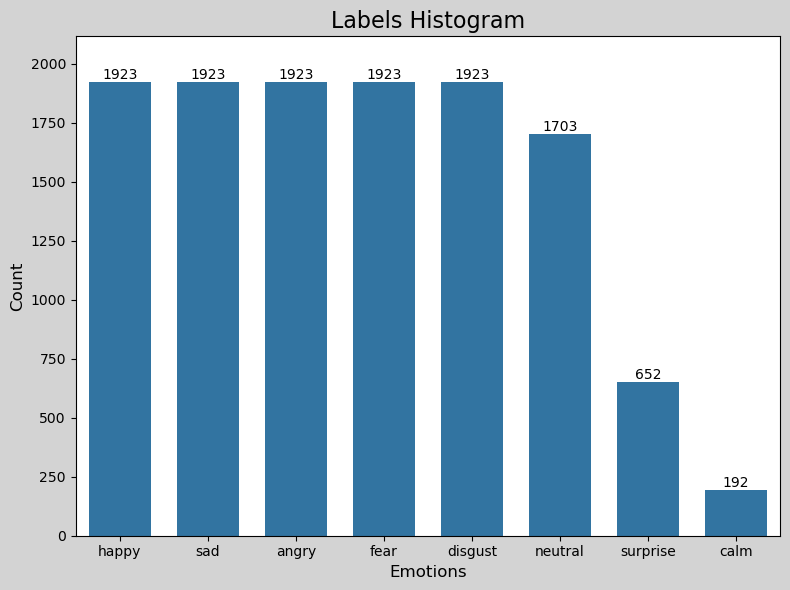

In [7]:
plot_labels_histogram(data, 'Emotions')

<u>We are dealing with imbalanced classes, lets review possible solutions: </u>  
As we can see, **calm** & **surprise** have fewer instances.  
1. **Class Weighting:** ML algorithms, such as logistic regression, decision trees, and random forests, support assigning different weights to classes.
2. **Oversampling:** Increasing the number of instances in the minority class to balance the class distribution. SMOTE (Synthetic Minority Over-sampling Technique), or bootstrapping.
3. **Undersampling:** Undersampling involves reducing the number of instances in the majority class to balance the class distribution. **Possible loss of valuable information.**
4. **Data Augmentation:** Creating new samples by applying augmentations to existing samples. This can improve the model's ability to generalize to minority classes.
5. **Ensemble Methods:** Ensemble methods, such as bagging and boosting, can be effective in handling imbalanced datasets. By combining multiple models trained on different subsets of the data, ensemble methods can improve the overall performance and robustness of the classifier.
6. **Evaluation Metrics:** It's essential to use appropriate evaluation metrics that account for class imbalance: precision, recall, F1-score, and area under the ROC curve (AUC-ROC).

<u>Drawbacks of having only a few instances of a specific class/label include:</u>
1. **Poor Generalization:** The model may struggle to generalize well to the minority class, leading to low performance on unseen data.
2. **Biased Predictions:** The model may exhibit bias towards the majority class, resulting in inaccurate predictions for the minority class.
3. **Misclassification:** Instances of the minority class may be misclassified more frequently, leading to higher false negative rates.

#### **Our Conclusion**
After further checking, we decided to join 'calm' and 'neutral' classes together.  The reason is that the signals are very similar and the main difference is the pace in which they talk - where 'calm' is slower then 'neutral' talk, thus even if the model could identify between these two, it would not be relevant for our use case.

In [8]:
print(len(column_labels))

172


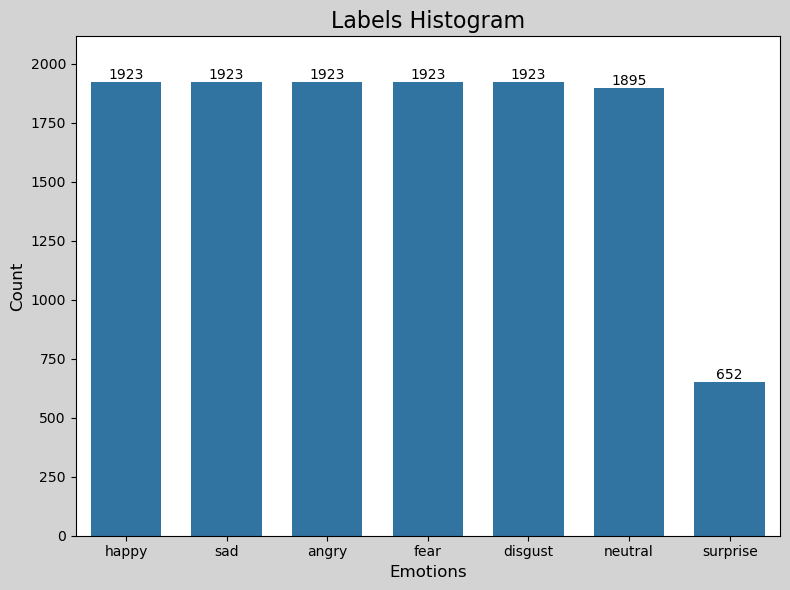

In [9]:
data['Emotions'] = data['Emotions'].replace('calm', 'neutral')

plot_labels_histogram(data, 'Emotions')

### **<u>Step 3:</u>** Split the Data into:
**Training Set** - Training datasets comprise samples used to fit machine learning models under construction. (Usually 80% of the data)  
**Validattion Set** - In contrast, validation datasets contain different samples to evaluate trained ML models. Working on validation data is used to assess the model performance and fine-tune the parameters of the model. This becomes an iterative process wherein the model learns from the training data and is then validated and fine-tuned on the validation set.  
**Testing Set** - Finally, a test data set is a separate sample, an unseen data set, to provide an unbiased final evaluation of a model fit.  
Augmentation should only be applied to the **Train Set**, and the **Test Set** remains **untouched** to provide an unbiased evaluation of model performance. 


In [10]:
# Split the DataFrame into training and testing sets
train_data_path, test_data_path = train_test_split(data, test_size=0.2, stratify=data['Emotions'], random_state=42)

# print the shape of the train and test data
print(f"Train data shape: {train_data_path.shape[0]} X {train_data_path.shape[1]}")
print(f"Test data shape: {test_data_path.shape[0]} X {test_data_path.shape[1]}")


Train data shape: 9729 X 2
Test data shape: 2433 X 2


### **<u>Step 4:</u>** Feature Extraction Pipeline
The audio data provided cannot be understood by the models directly so we need to convert it into an understandable format for which feature extraction is used. Audio signals can broadly be categorized as **stationary** or **non-stationary**. Stationary signals have spectrums that do not change over time, like pure tones. Non-stationary signals have spectrums that change over time, like speech signals. To make machine learning-based tasks tractable, non-stationary signals can be approximated as stationary when analyzed at appropriately small time scales. Generally, speech signals are considered stationary when viewed at time scales around 30 ms. Therefore, speech can be characterized by extracting features from 30 ms analysis windows over time.

Use the helper function, helperVisualizeBuffer, to visualize the analysis windows of an audio file. Specify a 30 ms analysis window with 20 ms overlap between adjacent windows. The overlap duration must be less than the window duration. The Analysis Windows of Signal plot shows the individual analysis windows from which features are extracted.  

Sample Rate: According to the Nyquist theorem, the sample rate should be at least twice the highest frequency component in the signal to avoid aliasing. For audio signals, the highest frequency of interest is typically around 20 kHz, so a sample rate of 44.1 kHz or higher (such as 48 kHz, 96 kHz) is commonly used for audio processing.

<u>The audio signal is a three-dimensional signal in which three axes represent **time**, **amplitude** and **frequency**</u>

<img src="https://www.mathworks.com/help/examples/audio_wavelet/win64/AudioFeatureSelectionForMachineLearningTasksExample_03.png" alt="image.png" width="400" height="300">

<img src="https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg" alt="image.png" width="400" height="300">

<img src="https://www.mathworks.com/help/examples/audio_wavelet/win64/AudioFeatureSelectionForMachineLearningTasksExample_04.png" alt="image.png" width="400" height="300">

<u>We use **sample rate** and the **sampled data**, and perform several transformations to extract valuable features:</u>
**Zero Crossing Rate** : The rate of sign-changes of the signal during the duration of a particular frame.  
**Energy** : The sum of squares of the signal values, normalized by the respective frame length.  
**Entropy of Energy** : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.  
**Spectral Centroid** : The center of gravity of the spectrum.  
**Spectral Spread** : The second central moment of the spectrum.  
**Spectral Entropy** :  Entropy of the normalized spectral energies for a set of sub-frames.  
**Spectral Flux** : The squared difference between the normalized magnitudes of the spectra of the two successive frames.  
**Spectral Rolloff** : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.  
**MFCCs Mel Frequency Cepstral Coefficients** : form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.  
**Chroma Vector** : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).  
**Chroma Deviation** : The standard deviation of the 12 chroma coefficients.  

In this project we try to go deep into feature selection process.

In [11]:
# Load features if available
Train_Features = pd.read_csv(train_features_path) if os.path.exists(train_features_path) else None
Test_Features = pd.read_csv(test_features_path) if os.path.exists(test_features_path) else None

In [12]:
# Start the timer
t1 = time.perf_counter()

# Extract train features if not defined or empty
if Train_Features is None:
    # train_features = extraction_loop(train_data_path[:2], 'train')
    train_features = extraction_loop(train_data_path, 'test')
    Train_Features = pd.DataFrame(train_features, columns=column_labels)
    # Normalized = False

# Extract test features if not defined or empty
if Test_Features is None:
    test_features = extraction_loop(test_data_path, 'test')
    Test_Features = pd.DataFrame(test_features, columns=column_labels)
    # Normalized = False
    
# End the timer
t2 = time.perf_counter()

print(f'Finished in {(t2-t1) / 60:.2f} minutes')

Finished in 0.00 minutes


In [13]:
x_train = Train_Features.iloc[:, :-2].values  # select all numeric columns
y_train = Train_Features['Emotion'].values    # Selecting the 'Emotion' column

x_test = Test_Features.iloc[:, :-2].values  # select all numeric columns
y_test = Test_Features['Emotion'].values    # Selecting the 'Emotion' column

print(f"Train Features shape: {Train_Features.shape[0]} X {Train_Features.shape[1]}")
print(f"Test Features shape: {Test_Features.shape[0]} X {Test_Features.shape[1]}")

TRAIN_SIZE = len(train_data_path)
TEST_SIZE = len(test_data_path)


Train Features shape: 9729 X 172
Test Features shape: 2433 X 172


### **<u>Step 4:</u>** Feature Scaling + Save the features DataFrame
<u>Normalize the data by subtracting the mean and divide the result by the standard deviation:</u>
$$ x' = \frac{{x - \mu}}{{\sigma}} $$


We do that scaling on the **training set**, then we apply the same scaling to our test set (e.g. in cross-validation), or to any newly obtained data features before forecasting. We have to use the exact same two parameters μ and σ (values which are saved as an internal object's state by scikit-learn) that we used for centering the **training set**.  
Internally, the transformer object just calls first fit() and then transform() on the same data.

In [14]:
Train_Features.to_csv(train_features_path, index=False)
Test_Features.to_csv(test_features_path, index=False)

In [15]:
# if not Normalized:
#     # Initialize the StandardScaler
#     scaler = StandardScaler()

#     # Fit and transform the training set & test set
#     x_train_normalized = scaler.fit_transform(x_train)
#     x_test_normalized = scaler.transform(x_test)

#     # Create a DataFrame with the normalized features and emotion labels for training data
#     Train_Features_Normalized = pd.DataFrame(x_train_normalized, columns=column_labels[:-2])
#     Test_Features_Normalized = pd.DataFrame(x_test_normalized, columns=column_labels[:-2])

#     # Add back labels and augmentation columns to the normalized data
#     Train_Features_Normalized['augmentation'] = Train_Features['augmentation']
#     Test_Features_Normalized['augmentation'] = Test_Features['augmentation']
#     Train_Features_Normalized['Emotion'] = y_train
#     Test_Features_Normalized['Emotion'] = y_test

#     # Save the normalized features to a CSV file
#     Train_Features_Normalized.to_csv(train_features_path, index=False)
#     Test_Features_Normalized.to_csv(test_features_path, index=False)

#     # Update the training and testing features
#     Train_Features = Train_Features_Normalized
#     Test_Features = Test_Features_Normalized

In [16]:
Train_Features

,zcr,C,C#,D,D#,E,F,F#,G,G#,...,contrast3,contrast4,contrast5,contrast6,contrast7,bandwidth,centroid,rolloff,augmentation,Emotion
0,0.022826,0.405201,0.423689,0.477401,0.628211,0.646499,0.598932,0.670891,0.673576,0.654742,...,16.807297,19.752803,16.402621,18.714392,59.684143,1432.669278,1010.272771,1838.799905,original,fear
1,0.046061,0.601858,0.600953,0.596976,0.613764,0.642070,0.693825,0.717149,0.798308,0.852220,...,14.249134,13.599008,13.508537,14.676625,64.748736,1987.872168,1608.495659,3365.878906,original,sad
2,0.036636,0.369544,0.321942,0.349853,0.385207,0.394370,0.371292,0.413867,0.497216,0.580945,...,22.452971,22.535534,21.071320,21.112880,65.090688,2229.972115,1767.837298,3131.055654,original,surprise
3,0.051772,0.631634,0.415285,0.305722,0.337436,0.409126,0.551563,0.398899,0.335396,0.351543,...,23.949829,24.962680,24.544245,25.288723,66.916467,2309.746749,2253.676989,4455.360598,original,fear
4,0.046218,0.643150,0.605809,0.510297,0.543817,0.596125,0.596295,0.594618,0.628413,0.663578,...,15.616694,17.496358,18.631052,18.206960,68.872011,1776.641813,1752.149070,3535.089393,original,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9724,0.024507,0.645299,0.666587,0.735339,0.641208,0.549271,0.590504,0.583540,0.601354,0.619396,...,14.896963,16.881345,15.715045,16.944136,62.136883,1542.757924,1074.726939,2025.707751,original,neutral
9725,0.052429,0.587731,0.557296,0.507526,0.537748,0.559530,0.608051,0.640832,0.664043,0.663490,...,15.258361,15.591448,18.477457,18.895264,61.884731,2173.195954,2243.276901,4212.574527,original,disgust
9726,0.027220,0.706795,0.649666,0.647090,0.677720,0.656016,0.602313,0.546630,0.581164,0.650011,...,14.798524,14.120355,16.791168,16.542032,62.835983,1782.382558,1306.696558,2863.916016,original,sad
9727,0.021387,0.585509,0.581733,0.564904,0.620268,0.678755,0.751830,0.817149,0.811273,0.782082,...,15.468674,13.381773,13.988253,14.553104,65.051905,1780.502992,1181.215882,2760.443308,original,fear


### **<u>Step 5:</u>** Read Train & Test Features

In [17]:
# Printing the shapes of the feature matrix (X) and target array (Y)
print(f"x_train shape: {x_train.shape[0]} X {x_train.shape[1]}")
print(f"y_train shape: {y_train.shape[0]} X 1")

# Printing the shapes of the test feature matrix (X) and target array (Y)
print(f"x_test shape: {x_test.shape[0]} X {x_test.shape[1]}")
print(f"y_test shape: {y_test.shape[0]} X 1")

x_train shape: 9729 X 170
y_train shape: 9729 X 1
x_test shape: 2433 X 170
y_test shape: 2433 X 1


### **<u>Step 6:</u>** Encode the Classes

In [18]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
encoded_string = ' '.join([str(int(x)) for x in Y_encoded[0]])
print(f"For example, {GREEN}{y_train[0]}{RESET} {BLUE}is{RESET} encoded {BLUE}as{RESET} {GREEN}{encoded_string}{RESET}")

For example, fear is encoded as 0 0 1 0 0 0 0


### **<u>Step 7:</u>** Model Selection and Training
**Logistic Regression:** A linear classifier used for binary classification tasks.  
**Decision Trees:** Versatile classifiers that split the data into subsets based on the values of input features.  
**Random Forests:** An ensemble learning method that builds multiple decision trees and combines their predictions to improve accuracy and reduce overfitting.  
**Support Vector Machines (SVM):** Used for binary and multi-class classification tasks by finding the hyperplane that best separates the classes in the feature space.  
**K-Nearest Neighbors (KNN):** A simple algorithm that classifies new data points based on the majority class of their k nearest neighbors in the feature space.  
**Naive Bayes:** A probabilistic classifier based on Bayes' theorem, often used for text classification tasks.  
**Gradient Boosting Machines (GBM):** An ensemble learning technique that builds a sequence of weak learners (typically decision trees) and combines their predictions to improve accuracy.  
**AdaBoost:** Another ensemble learning method that combines multiple weak classifiers to build a strong classifier.  
**Bagging:** A technique that builds multiple classifiers (typically decision trees) on different subsets of the training data and combines their predictions through averaging or voting.  
**Ensemble Voting:** Combining predictions from multiple classifiers (e.g., logistic regression, decision trees, SVM) to make a final prediction based on majority voting or averaging.  
**Gaussian Naive Bayes:** A variant of Naive Bayes suitable for continuous input features, assuming that features follow a Gaussian distribution.  
**Quadratic Discriminant Analysis (QDA):** A classification algorithm similar to Gaussian Naive Bayes, but it allows for different covariance matrices for each class.  

**<u>OUR TOP 3 CANDIDATES:</u>**  

**[Random Forests:](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)** is considered one of the top choices for multiclass classification tasks: highly versatile, perform well on a wide range of datasets, and are less prone to overfitting compared to individual decision trees.Capable of handling numerical and categorical features and can capture complex relationships in the data.  

**[Support Vector Machines (SVM):](https://scikit-learn.org/stable/modules/svm.html#kernel-functions)** SVMs are powerful classifiers that work well for multiclass classification tasks. They find the hyperplane that best separates the classes in the feature space, making them effective for high-dimensional data with complex decision boundaries.  

**[Gradient Boosting Machines (GBM):](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)** Gradient Boosting Machines, such as XGBoost, LightGBM, and CatBoost, are widely used for multiclass classification tasks due to their high predictive accuracy and robustness. GBMs build a sequence of weak learners (typically decision trees) and combine their predictions to improve accuracy. They often outperform other classifiers on structured/tabular data and are highly customizable with various hyperparameters to tune.


In [19]:
# class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
# model = RandomForestClassifier(class_weight=dict(zip(np.unique(y_train), class_weights)), random_state=42)

classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Linear kernel SVM': SVC(kernel='linear'),
    'Radial Basis Function (RBF) kernel SVM': SVC(kernel='rbf'),
    'Gradient Boosting': GradientBoostingClassifier()
    }

progress_bar = tqdm(total=len(classifiers), desc='Progress', unit='classifier')

for clf_name, clf in classifiers.items():
    progress_bar.update(1)
    classifiers[clf_name] = train_classifier(clf, clf_paths[clf_name], x_train, y_train)

progress_bar.close()

Progress: 100%|██████████| 4/4 [00:00<00:00, 40.00classifier/s]


### **<u>Step 6:</u>** Model Evaluation
We evaluate our model before searching before feature importance because we don't want to search on a poorly operating model. For feature importance to have any meaning, it has to be extracted from a good performing trained model. 

Print Report  
Plot Confusion Matrix  

Model: Random Forest Classifier
Training size: 9729
Testing size: 2433
Training score: 0.60

Prediction Train Accuracy: 99.97%
Prediction Test Accuracy: 60.30%

              precision    recall  f1-score   support

     neutral       0.69      0.78      0.73       385
       happy       0.56      0.45      0.50       384
         sad       0.64      0.40      0.49       385
       angry       0.53      0.55      0.54       385
        fear       0.54      0.73      0.62       379
     disgust       0.60      0.66      0.63       385
    surprise       0.79      0.77      0.78       130

    accuracy                           0.60      2433
   macro avg       0.62      0.62      0.61      2433
weighted avg       0.61      0.60      0.60      2433



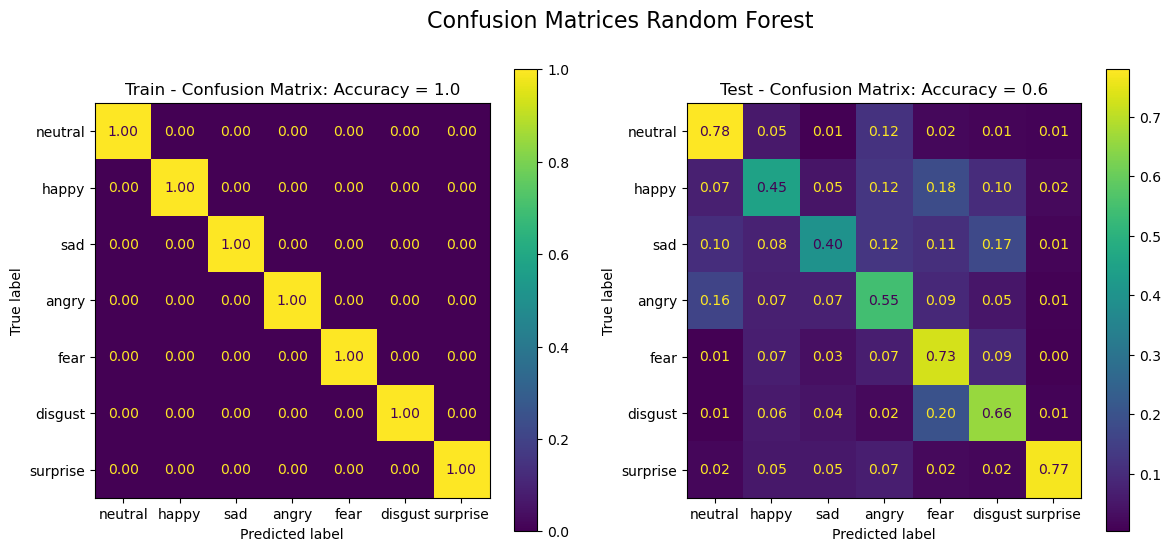

Model: Linear kernel SVM Classifier
Training size: 9729
Testing size: 2433
Training score: 0.49

Prediction Train Accuracy: 53.16%
Prediction Test Accuracy: 49.20%

              precision    recall  f1-score   support

     neutral       0.57      0.68      0.62       385
       happy       0.40      0.40      0.40       384
         sad       0.44      0.41      0.43       385
       angry       0.44      0.35      0.39       385
        fear       0.50      0.52      0.51       379
     disgust       0.55      0.56      0.55       385
    surprise       0.58      0.58      0.58       130

    accuracy                           0.49      2433
   macro avg       0.50      0.50      0.50      2433
weighted avg       0.49      0.49      0.49      2433



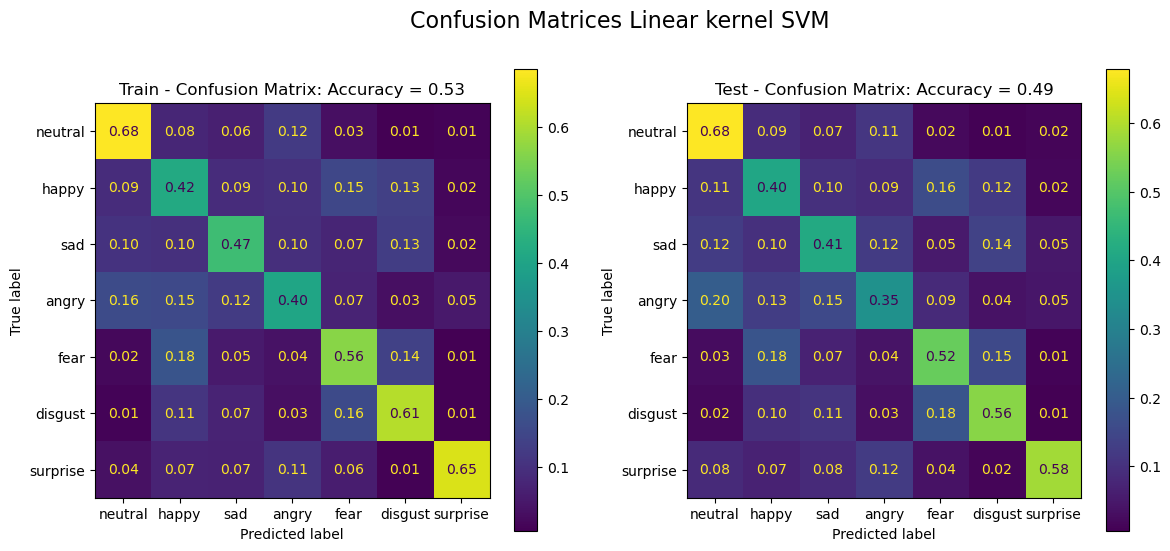

Model: Radial Basis Function (RBF) kernel SVM Classifier
Training size: 9729
Testing size: 2433
Training score: 0.30

Prediction Train Accuracy: 29.93%
Prediction Test Accuracy: 30.05%

              precision    recall  f1-score   support

     neutral       0.38      0.61      0.46       385
       happy       0.23      0.27      0.25       384
         sad       0.22      0.03      0.05       385
       angry       0.32      0.08      0.13       385
        fear       0.30      0.24      0.26       379
     disgust       0.29      0.65      0.40       385
    surprise       0.26      0.08      0.12       130

    accuracy                           0.30      2433
   macro avg       0.28      0.28      0.24      2433
weighted avg       0.29      0.30      0.25      2433



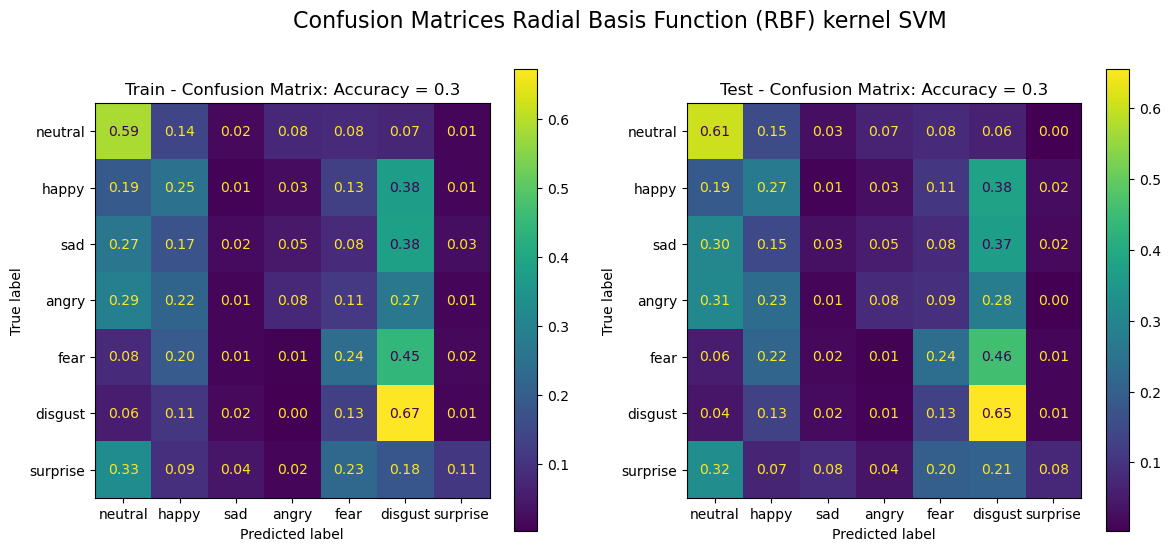

Model: Gradient Boosting Classifier
Training size: 9729
Testing size: 2433
Training score: 0.59

Prediction Train Accuracy: 75.86%
Prediction Test Accuracy: 59.23%

              precision    recall  f1-score   support

     neutral       0.68      0.77      0.72       385
       happy       0.52      0.46      0.48       384
         sad       0.60      0.44      0.51       385
       angry       0.53      0.52      0.53       385
        fear       0.55      0.68      0.61       379
     disgust       0.60      0.64      0.62       385
    surprise       0.78      0.75      0.76       130

    accuracy                           0.59      2433
   macro avg       0.61      0.61      0.60      2433
weighted avg       0.59      0.59      0.59      2433



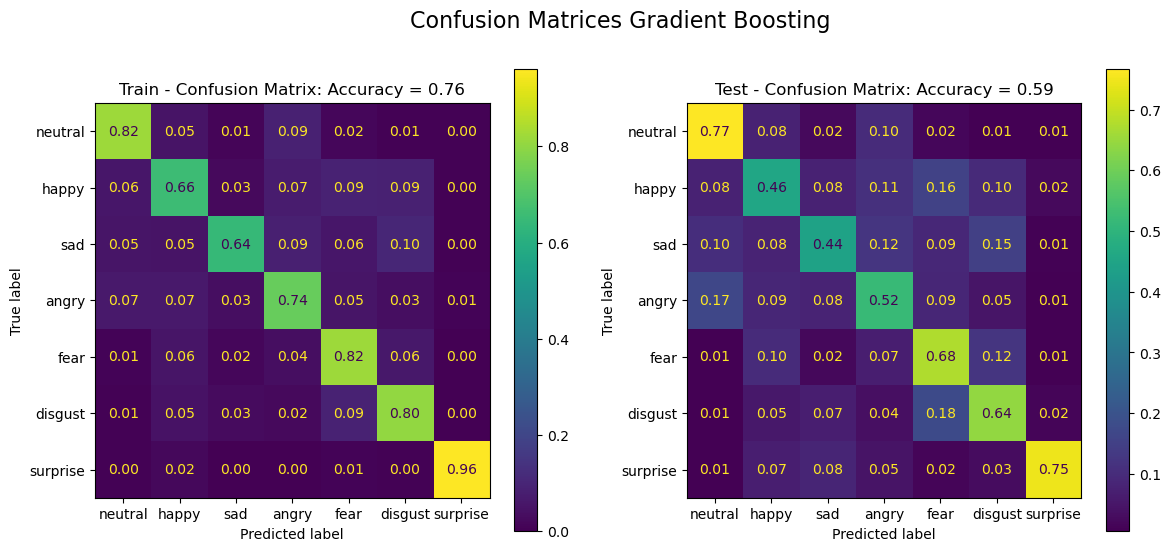

In [20]:
for clf_name, clf in classifiers.items():
    clf = model_eval(clf, clf_name, x_train, x_test, y_train, y_test)

In [21]:
for name, clf in classifiers.items():
    print(f"Model: {name}, score: {clf.score(x_test, y_test):.2f}" )

Model: Random Forest, score: 0.60
Model: Linear kernel SVM, score: 0.49
Model: Radial Basis Function (RBF) kernel SVM, score: 0.30
Model: Gradient Boosting, score: 0.59


### **<u>Step 7:</u>** Extract Feature Importance

### SVM

When training an SVM with the Radial Basis Function (RBF) kernel, two parameters must be considered: C and gamma. The parameter C, common to all SVM kernels, trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.  

Proper choice of C and gamma is critical to the SVM’s performance. One is advised to use GridSearchCV with C and gamma spaced exponentially far apart to choose good values.

1. ZCR (1 features)
2. Chroma (12 features)
3. MFCC (20 features)
4. RMS (1 features)
5. PSD (120 features)
6. AHSM (6 features)
7. Contrast (7 features)
8. Bandwidth (1 features)
9. Centroid (1 features)
10. Rolloff (1 features)


Progress:  50%|█████     | 2/4 [10:49<10:49, 324.99s/classifier]


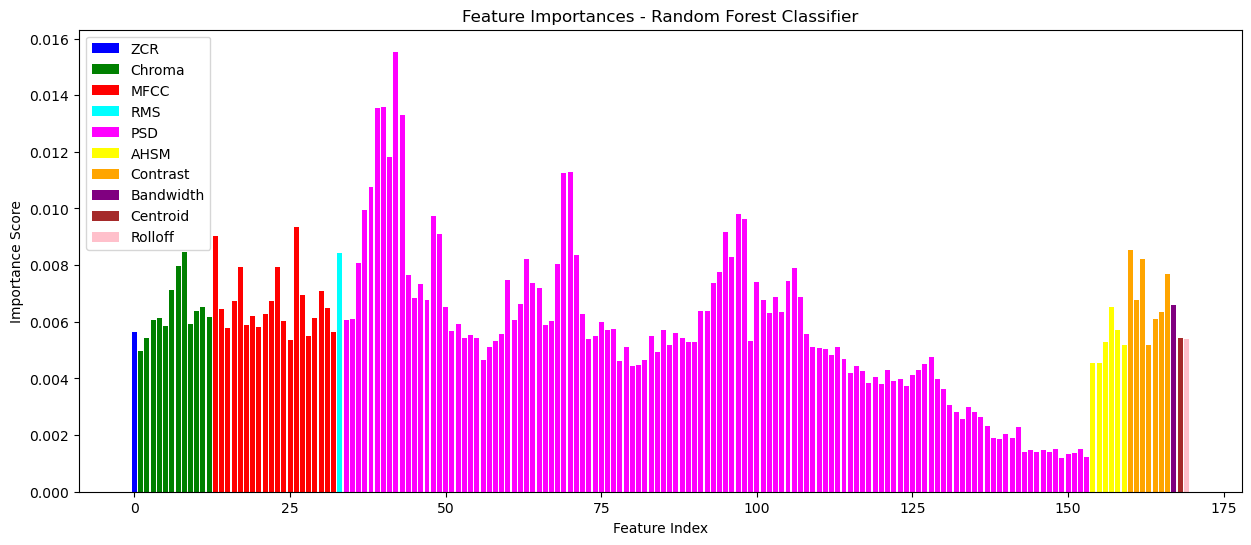

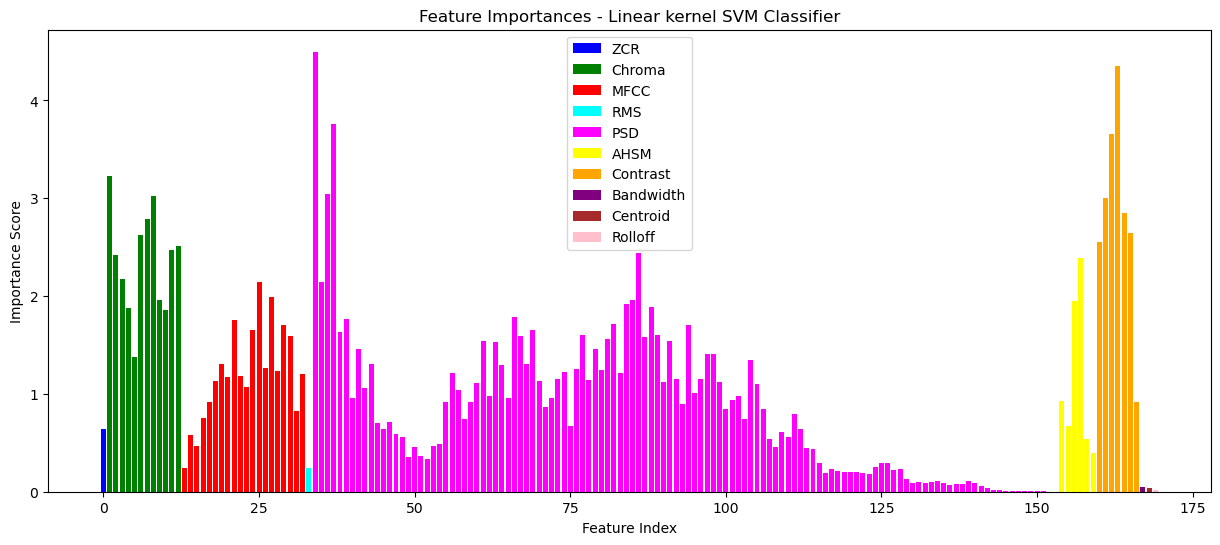

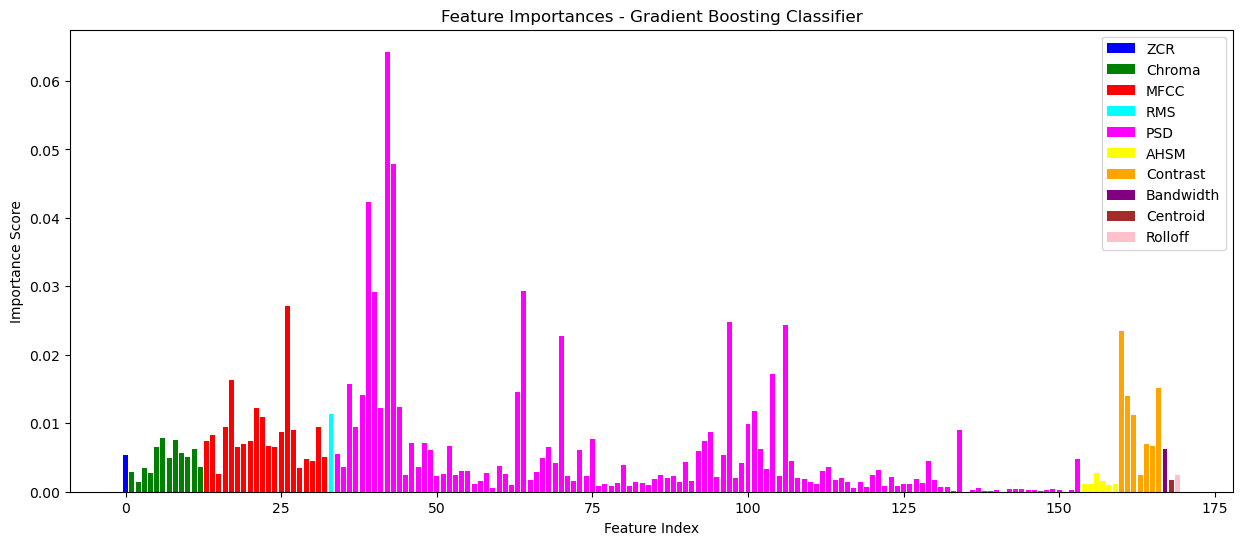

Progress:  75%|███████▌  | 3/4 [00:00<00:00,  3.34classifier/s]


In [23]:
# Save features feature_groups is not empty
feature_groups = feature_groups or load_feature_groups()
save_feature_groups(feature_groups)
    
for i, (label, size) in enumerate(feature_groups.items()):
    print(f"{i+1}. {label} ({size} features)")

progress_bar = tqdm(total=len(classifiers), desc='Progress', unit='classifier')
for model_name, model in classifiers.items():
    if model_name == 'Radial Basis Function (RBF) kernel SVM':
        continue
    plot_feature_importance(model, model_name, x_train, y_train)
    progress_bar.update(1)        
progress_bar.close()
# Radial Basis Function SVM takes more time to compute feature importance because it is using 'permutation_importance' to calculate feature importance

### OUR FAVORITE CANDIDATE

Random Forest Classifier  
Now, lets check out what we get with 'permutation_importance'.

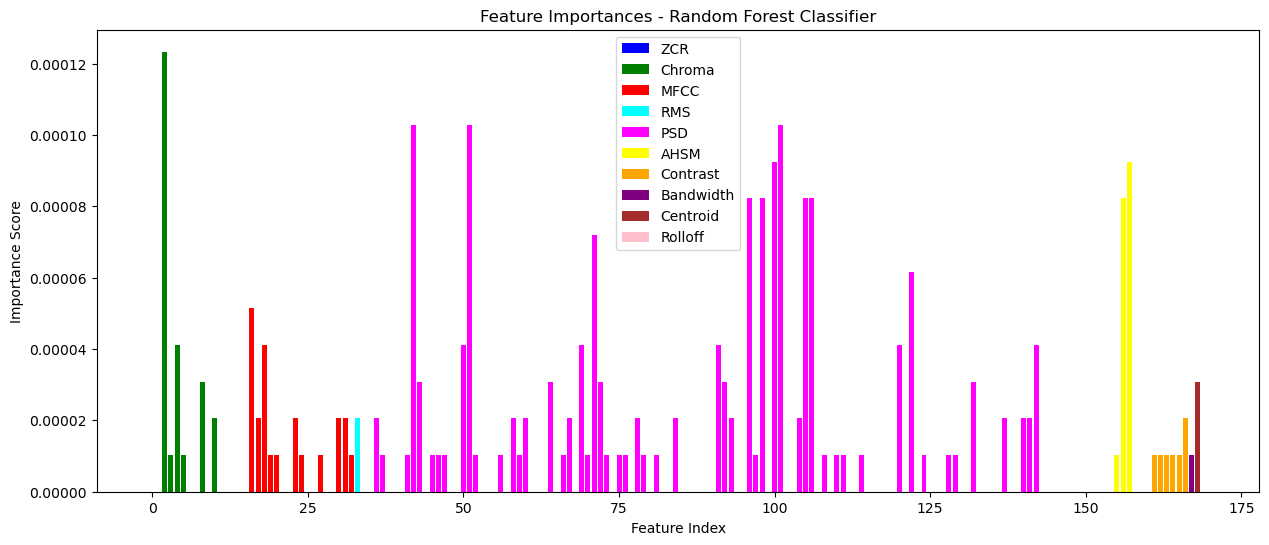

In [24]:
plot_permutation_importance(classifiers['Random Forest'], 'Random Forest', x_train, y_train)

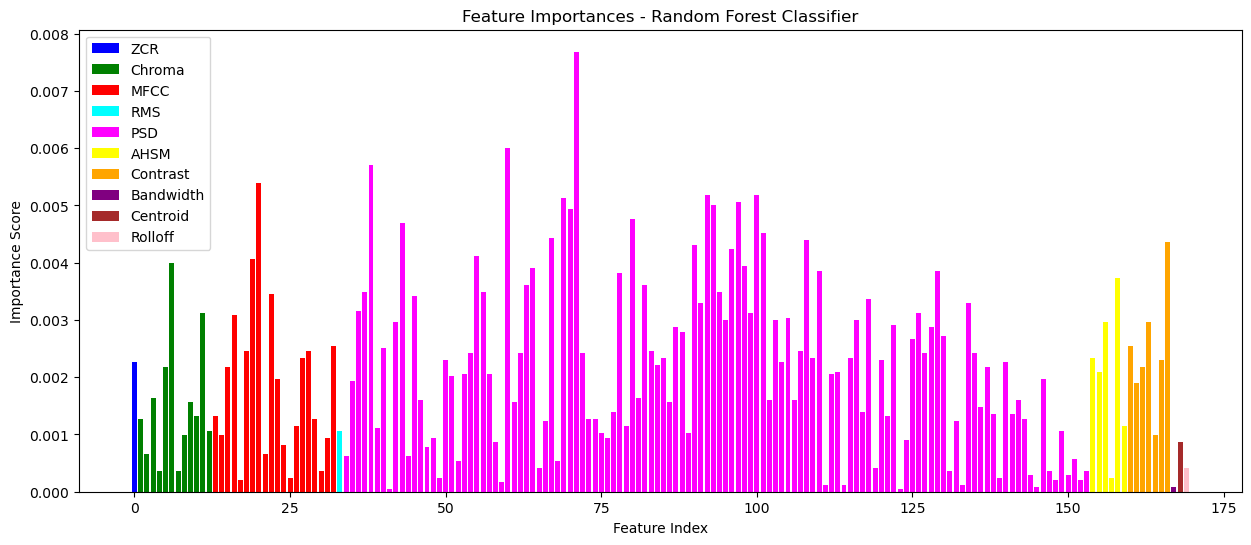

In [25]:
plot_permutation_importance(classifiers['Random Forest'], 'Random Forest', x_test, y_test)

#### **RANDOM FOREST - CONCLUSIONS**
Random Forest Classifier had the best training score, with also high test score. We concluded that we can probably explain this gap of 30% between them by overfitting the model to the training set. 
We could probably raise the the test accuracy by:

<u>lets look at the results:</u>  
Training size: 9729  
Testing size: 2433  
Prediction Train Accuracy: 0.99  
Prediction Test Accuracy: 0.6  

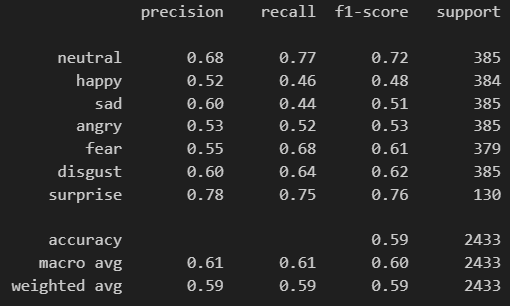

### **<u>Step 9:</u>** Correlation Heat Map

(170, 170)


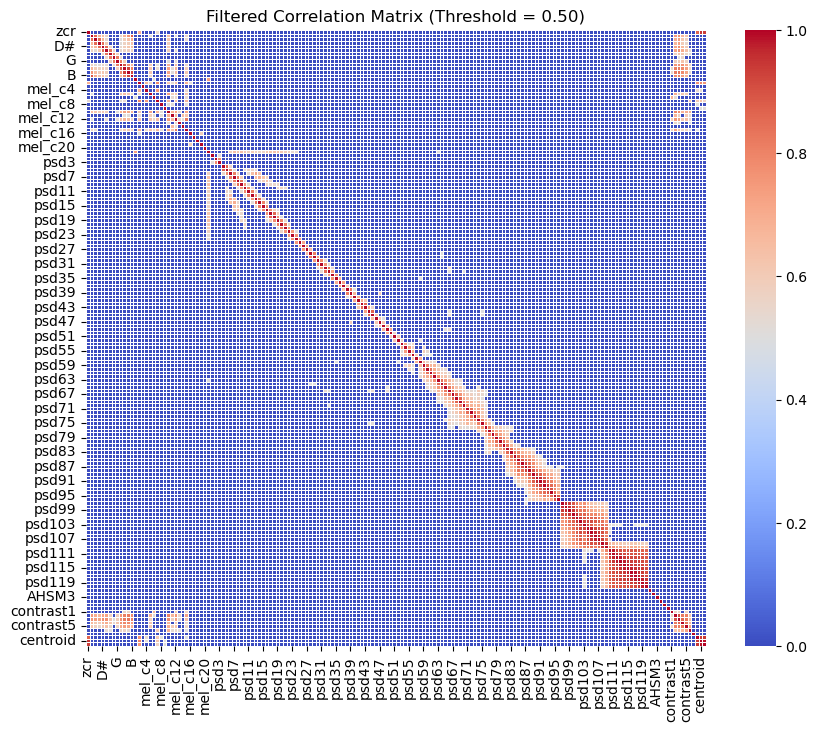

In [26]:
# Drop the 'Emotion' column to get the features
features = Train_Features.drop(columns=['Emotion', 'augmentation'])

# Calculate the correlation matrix
corr_matrix = features.corr()

# print shape of the correlation matrix
print(corr_matrix.shape)

# Set correlation threshold
threshold = 0.5

# Filter out correlations below the threshold
corr_matrix_filtered = corr_matrix.abs()  # Take absolute values to consider negative correlations as well
corr_matrix_filtered = corr_matrix_filtered.mask(corr_matrix_filtered < threshold, 0)

# Plot the filtered correlation heatmap without annotations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_filtered, cmap='coolwarm', linewidths=0.5)
plt.title('Filtered Correlation Matrix (Threshold = {:.2f})'.format(threshold))
plt.show()

### **<u>Step 10:</u>** Dimensional Reduction - PCA
We use Principal Component Analysis (PCA) to reduce the number of features and improve computational efficiency, reduce the dimensionality of the feature space, remove noise from the dataset while retaining most of the information. 

Also, lets look at the correlation heatmap after dimensionality reduction:

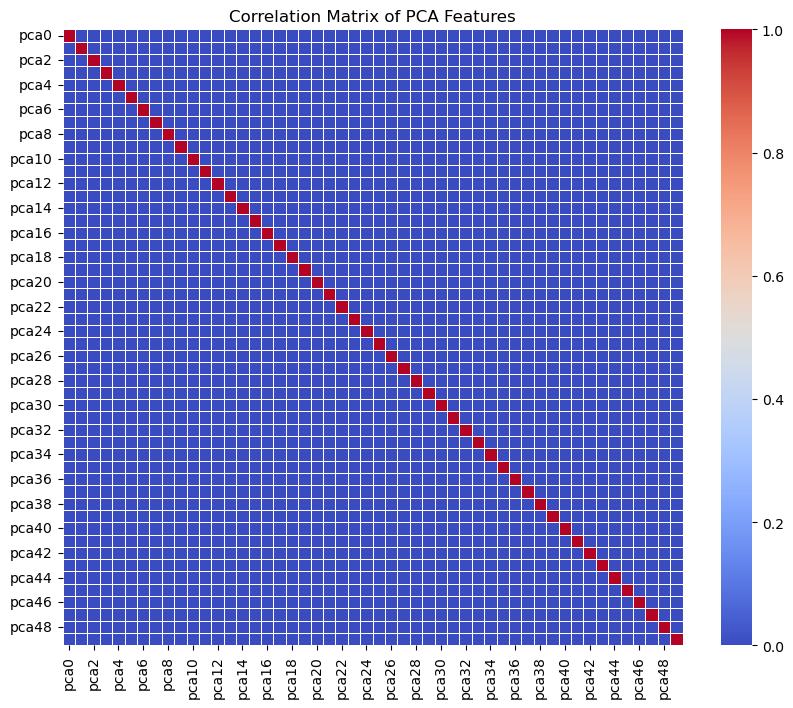

Size of PCA transformed features: 50 vs Size of original features: 170


In [27]:
from sklearn.decomposition import PCA

# Apply PCA conserving 40 out of 170 features (40/170 = 23.5% of the variance)
pca = PCA(n_components=50).set_output(transform="pandas")
x_train_transformed = pca.fit_transform(Train_Features.drop(columns=['Emotion', 'augmentation']))

# Plot the correlation heatmap for the PCA features
corr_matrix_pca = x_train_transformed.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_pca, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of PCA Features')
plt.show()

# Print the shape of the PCA features
print(f"Size of PCA transformed features: {x_train_transformed.shape[1]} vs Size of original features: {x_train.shape[1]}")


Train the model again, this time with less features, after filtering them using PCA library

Model: PCA - Random Forest Classifier
Training size: 9729
Testing size: 2433
Training score: 0.61

Prediction Train Accuracy: 99.97%
Prediction Test Accuracy: 60.87%

              precision    recall  f1-score   support

     neutral       0.69      0.77      0.73       385
       happy       0.55      0.44      0.49       384
         sad       0.68      0.43      0.53       385
       angry       0.53      0.54      0.54       385
        fear       0.58      0.76      0.66       379
     disgust       0.59      0.66      0.62       385
    surprise       0.79      0.74      0.76       130

    accuracy                           0.61      2433
   macro avg       0.63      0.62      0.62      2433
weighted avg       0.61      0.61      0.60      2433



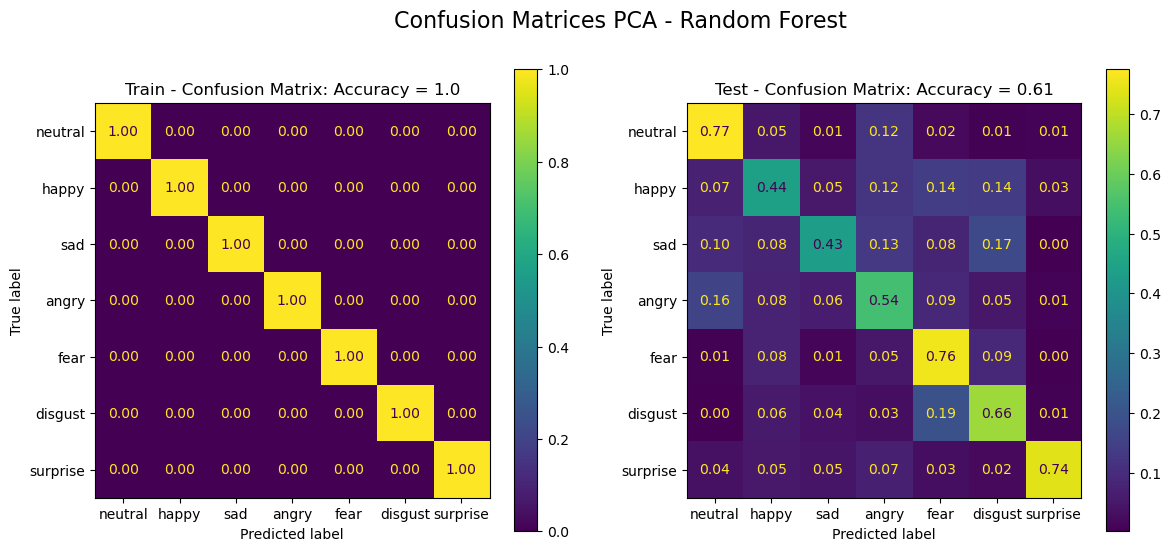

In [28]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Step 1: transform test data using already fitted pca
x_test_transformed = pca.transform(Test_Features.drop(columns=['Emotion', 'augmentation']))
pca_y_train = Train_Features['Emotion']
pca_y_test = Test_Features['Emotion']

# Step 2: Normalize the data
pca_x_train_scaled = scaler.fit_transform(x_train)
pca_x_test_scaled = scaler.transform(x_test)

# Step 3: Train the model using the PCA training data
model = RandomForestClassifier() 
model.fit(pca_x_train_scaled, pca_y_train)

# Step 4: print report
model_eval(model, "PCA - Random Forest", pca_x_train_scaled, pca_x_test_scaled, pca_y_train, pca_y_test)

### High-dimensional PCA Analysis with px.scatter_matrix
The dimensionality reduction technique we will be using is called the [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/decomposition.html#pca). It is a powerful technique that arises from linear algebra and probability theory. In essence, it computes a matrix that represents the variation of your data ([covariance matrix/eigenvectors](https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues#:~:text=As%20it%20is%20a%20square%20symmetric%20matrix%2C%20it%20can%20be%20diagonalized%20by%20choosing%20a%20new%20orthogonal%20coordinate%20system%2C%20given%20by%20its%20eigenvectors%20(incidentally%2C%20this%20is%20called%20spectral%20theorem)%3B%20corresponding%20eigenvalues%20will%20then%20be%20located%20on%20the%20diagonal.%20In%20this%20new%20coordinate%20system%2C%20the%20covariance%20matrix%20is%20diagonal%20and%20looks%20like%20that%3A)), and rank them by their relevance (explained variance/eigenvalues).

### Visualize all the original dimensions
First, let's plot all the features and see how the emotions in the datasets are grouped. In a Scatter Plot Matrix (splom), each subplot displays a feature against another, so if we have $N$ features we have a $N \times N$ matrix.
In this example, we will use Plotly Express, Plotly's high-level API for building figures.

In [31]:
import optuna # type: ignore

# Adding random feature to features set
train_features_norm_rand = np.concatenate((train_features_norm, np.random.rand(train_features_norm.shape[0],1)),axis=1)
test_features_norm_rand = np.concatenate((test_features_norm, np.random.rand(test_features_norm.shape[0],1)),axis=1)

# Train with random feature
report, score, model = lib.TestClassificationModel(train_features_norm_rand,train_labels,test_features_norm_rand,test_labels,3, paramC=1,kernelType='rbf',n_estimators=100,min_samples_split=6,random_state=1, plot=True)

# Extract feature_importance of the model
feature_importance = lib.FeaturesImportance(model, train_features_norm_rand)

# Find the minimal threshold of feature_importance
feature_importance_min = feature_importance[len(feature_importance)-1]

# Train model for optuna tests
def TrainModel(train_data,train_labels,test_data,test_labels):
    oModel = RandomForestClassifier(n_estimators=100,min_samples_split=6,random_state=1,n_jobs=-1)
    oModel.fit(train_data,train_labels)
    accuracy = oModel.score(test_data,test_labels)
    return accuracy

# Select important features by threshold
def FeaturesSelect(train_features, test_features,features, features_threshold):
    weak_features_indexes = np.where(features < features_threshold)[0]
    train_features_selected = np.delete(train_features,weak_features_indexes,axis=1)
    test_features_selected = np.delete(test_features,weak_features_indexes,axis=1)
    n_feat = train_features_selected.shape[1]
    return train_features_selected,test_features_selected,n_feat

# Test by feature_importance treshold
def TestByFeatureImportanceThreshold(threshold):
    # Remove weak features
    train_features_selected,test_features_selected,n_feat = FeaturesSelect(train_features_norm_rand, test_features_norm_rand, feature_importance,threshold)
    # Test selected features
    accuracy = TrainModel(train_features_selected, y_train,test_features_selected, y_test)
    return accuracy, n_feat

# Optuna object function for searchin threshold
def oFeatureImportanceThreshold(trial):
    feature_importance_threshold = trial.suggest_float("thr", feature_importance_min, np.max(feature_importance)-1e-12)
    score, n_feat = TestByFeatureImportanceThreshold(feature_importance_threshold)
    return score

# Constract Optuna object
study_name="FeatureImportanceThreshold_12"
study = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)

# Run optuna, searching for best threshold, Test the model with best params
study.optimize(oFeatureImportanceThreshold, n_trials=100)
score, n_feat = TestByFeatureImportanceThreshold(study.best_params['thr'])
print(f"Best score: {score} (n_feat: {n_feat}, threshold: {study.best_params})")

model = classifiers['Random Forest']
feature_importance = model.feature_importances_

def oFeatureImportanceThreshold(trial):
    feature_importance_threshold = trial.suggest_float("thr", 0, np.max(feature_importance)-1e-12)
    score, n_feat = TestByFeatureImportanceThreshold(feature_importance_threshold)
    return score
study_name="FeatureImportanceThreshold_11"
study = optuna.create_study(
    study_name=study_name,
    storage=f"sqlite:///{study_name}.db",  # Specify the storage URL here.
    direction='maximize'
)
study.optimize(oFeatureImportanceThreshold, n_trials=100)
score, n_feat = TestByFeatureImportanceThreshold(study.best_params['thr'])
print(f"Best score: {score} (n_feat: {n_feat}, threshold: {study.best_params})")

[I 2024-05-04 12:03:29,193] A new study created in RDB with name: FeatureImportanceThreshold_11
[W 2024-05-04 12:03:29,217] Trial 0 failed with parameters: {} because of the following error: NameError("name 'feature_importance' is not defined").
Traceback (most recent call last):
  File "c:\Users\Netanel\mambaforge\envs\SER\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Netanel\AppData\Local\Temp\ipykernel_34740\1703347855.py", line 4, in oFeatureImportanceThreshold
    feature_importance_threshold = trial.suggest_float("thr", 0, np.max(feature_importance)-1e-12)
                                                                        ^^^^^^^^^^^^^^^^^^
NameError: name 'feature_importance' is not defined. Did you mean: 'plot_feature_importance'?
[W 2024-05-04 12:03:29,223] Trial 0 failed with value None.


NameError: name 'feature_importance' is not defined

In [29]:
# import plotly.express as px

# featurs = ["pca0", "pca1", "pca2", "pca3", "pca4", "pca5", "pca6", "pca7"]

# print(len(pca_features))
# fig = px.scatter_matrix(
#     pca_features,
#     dimensions=featurs,
#     color="Emotion",
# )
# fig.update_traces(diagonal_visible=False)
# fig.show()

### Optimal Feature Selection
Lets find the optimal combination of features based on permutation importance and evaluate their performance on the test set:

1. Identify the features with the highest permutation importance values.
2. Create subsets of the training and test sets using only these important features.
3. Train a model using the subset of important features on the training set.
4. Evaluate the model's performance on the test set.
5. Repeat steps 3-4 for different combinations of important features and select the combination that gives the best performance on the test set.

In [30]:
# score = cross_val_score(model, x_train, y_train, cv=5).mean()
# model = classifiers['Random Forest']
# perm_importance = permutation_importance(model, x_train, y_train, n_repeats=30, random_state=10, n_jobs=-1, scoring='accuracy')
# perm_importance = save_permutation_importance(classifiers['Random Forest'], perm_importance, 'Random Forest', permu_im_path)

# threshold = 0.00002

# # Step 1: Identify features with high permutation importance
# important_features = np.where(perm_importance.importances_mean > threshold)[0]
# print("Important Features:", important_features)

# best_score = 0
# best_feature_combination = None

# # Step 2: Iterate over combinations of important features
# for r in range(1, len(important_features) + 1):
#     for subset in combinations(important_features, r):
#         subset = list(subset)
#         x_train_subset = x_train[:, subset]
#         x_test_subset = x_test[:, subset]
        
#         # Step 3: Train a model using the subset of features
#         model.fit(x_train_subset, y_train)
        
#         # Step 4: Evaluate the model's performance
#         score = cross_val_score(model, x_test_subset, y_test, cv=5).mean()
        
        
#         # Step 5: Update best score and feature combination
#         if score > best_score:
#             best_score = score
#             best_feature_combination = subset

# print("Best feature combination:", best_feature_combination)
# print("Best cross-validation score:", best_score)

Important Features: [  2   7  42  50  51  69  71  73  96  98 100 101 105 106 122 156 157]


KeyboardInterrupt: 

### **<u>Step 11:</u>** Cross-Validation
Cross-validation is a robust technique used to assess the performance of machine learning models by splitting the dataset into multiple subsets and training the model on different combinations of these subsets. In a multiclass classification project, you can perform cross-validation using techniques such as k-fold cross-validation or stratified k-fold cross-validation.

1. <u>k-fold Cross-Validation:</u>
- In k-fold cross-validation, the dataset is divided into k equal-sized folds.
- The model is trained k times, each time using k-1 folds as training data and the remaining fold as validation data.
- The performance metrics are averaged over the k iterations to get a more reliable estimate of the model's performance.

When performing cross-validation, we use different random states for each fold ( in our classifier). This helps in assessing the robustness of the model across different random splits of the data. You can try multiple random states and average the results to get a more reliable estimate of model performance.

<u>Test set:</u>  
Important Features: [ 36  37  38  42  43 166]  
Best feature combination: [36, 37, 38, 42, 43, 166]  
Best cross-validation score: 0.4496598811907961  

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Define the number of folds
num_folds = 20

# Perform k-fold cross-validation
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
scores = cross_val_score(model, pca_x_train, pca_y_train, cv=kfold, scoring='accuracy')

# Print the average accuracy across all folds
print(f"Average Accuracy: {scores.mean()}, with: {kfold}")

Average Accuracy: 0.5752441541826321, with: KFold(n_splits=20, random_state=42, shuffle=True)


2. <u>Stratified k-fold Cross-Validation:</u>
- Stratified k-fold cross-validation maintains the class distribution in each fold, ensuring that each fold is representative of the overall class distribution.
- This is particularly useful for imbalanced datasets where some classes may have fewer samples than others.

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Perform stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
skf_scores = cross_val_score(model, pca_x_train, pca_y_train, cv=kfold, scoring='accuracy')

# Print the average accuracy across all folds
print(f"Average Accuracy: {skf_scores.mean()}, with: {skf}")

Average Accuracy: 0.5794469967834122, with: StratifiedKFold(n_splits=20, random_state=42, shuffle=True)


### **<u>Step 12:</u>** Hyperparameter Tuning
Tuning hyperparameters using techniques like grid search or random search:
We specify a fixed **random state** to ensure that the results are consistent across different runs. This allows us to compare the performance of different hyperparameter configurations accurately.

### **<u>Step 13:</u>** Grid Search
When performing grid search to find the best hyperparameters, we can include the following parameters as our chosen hyperparameters to search over:
1. random state

In [ ]:
import numpy as np

# Example correlation matrix (replace with your actual correlation matrix)
correlation_matrix = np.array([[1.0, 0.8, 0.2, 0.7],
                                [0.8, 1.0, 0.6, 0.4],
                                [0.2, 0.6, 1.0, 0.9],
                                [0.7, 0.4, 0.9, 1.0]])

# Correlation threshold
correlation_threshold = 0.6

# Find highly correlated features
highly_correlated_features = []

# Iterate through the upper triangle of the correlation matrix
num_features = correlation_matrix.shape[0]
for i in range(num_features):
    for j in range(i+1, num_features):
        correlation = correlation_matrix[i, j]
        if abs(correlation) >= correlation_threshold:
            # Check if the features are already in a subset
            found_subset = False
            for subset in highly_correlated_features:
                if i in subset or j in subset:
                    subset.add(i)
                    subset.add(j)
                    found_subset = True
                    break
            if not found_subset:
                highly_correlated_features.append({i, j})

# Convert subsets to list of feature names
feature_names = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']  # Replace with actual feature names
highly_correlated_features_names = []
for subset in highly_correlated_features:
    subset_names = [feature_names[i] for i in subset]
    highly_correlated_features_names.append(subset_names)

print(highly_correlated_features_names)


### Action Items:


<font color='yellow'>19/04 - 21/04</font>

1) <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Share Data - Organize and share cleaned data with Izhar and Netanel by compressing it into a ZIP file and placing it under the "data" folder within the project directory. Ensure to update the project's ignore file to include this data path. <font color='blue'>Victor</font>
    </label><br>
    
2) Target definition:  
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Define our primary objective or target score based on our specific use case and objectives. <font color='magenda'>Yizhar</font>,<font color='green'>Netanel</font>,<font color='blue'>Victor</font>
    </label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Work on refining scoring methods. <font color='magenda'>Yizhar</font>,<font color='green'>Netanel</font>,<font color='blue'>Victor</font>
    </label><br>
    
3) Integration and Refactoring - Merge our codebases into a unified project for seamless collaboration:  
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Refine the correlation heatmap to display correlations between different features, aiming to identify redundant features, reduce runtime, and enhance efficiency. <font color='blue'>Victor</font></label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Revamp the feature importance plot according to Netanel's implementation, ensuring visual clarity with colors, titles, and labels. <font color='green'>Netanel</font></label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Adjust the label histogram orientation to vertical and integrate it into our workflow to visualize the data before and after splitting. <font color='green'>Netanel</font></label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Convert Victor's feature data from Numpy objects to Pandas for seamless integration and utilize the opportunity to familiarize ourselves with Pandas functionality. <font color='blue'>(Victor)</font></label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Refactor lengthy functions into smaller, more manageable ones to enhance code readability and project structure. <font color='blue'>Victor</font></label><br>
    
4) Feature Engineering methods - Work on refining features, dimensionality reduction techniques, and feature selection strategies:  
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Develop a function to filter out less important features, determining a suitable threshold collaboratively.  <font color='blue'>Victor</font></label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Utilize efficient methods such as scatter transform. <font color='red'>(???)</font></label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Lasso for feature selection without resorting to loops. <font color='blue'>Victor</font></label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Apply PCA for dimensionality reduction, setting 'explained_variance_ratio' to retain 95% of the feature efficiency while reducing the feature count. <font color='red'>(???)</font></label><br>
    
5) <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">MiniRocket - Finilyze this method and get its best contribution for feature extraction. <font color='magenda'>Yizhar</font></label><br>

<font color='yellow'>22/04 - 30/04   (Some of us will not be available part of these days due to Passover holiday)</font>

6)  <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">GridSearch - Determine the hyperparameters to optimize and prepare for grid search using sklearn. Employ 'n_jobs' to expedite the parameter tuning process. <font color='magenda'>Yizhar</font>,<font color='green'>Netanel</font>,<font color='blue'>Victor</font></label><br> 


<font color='yellow'>01/05 - 04/05</font>

7) Presentation:  
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Collaboratively select a presentation template and distribute responsibilities for slide creation (10-15 slides total). <font color='magenda'>Yizhar</font>,<font color='green'>Netanel</font>,<font color='blue'>Victor</font></label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Edit the presentation content, ensuring each slide clearly communicates its intended message with relevant plots, formulas, and explanations. <font color='magenda'>Yizhar</font>,<font color='green'>Netanel</font>,<font color='blue'>Victor</font></label><br>
    <input type="checkbox" id="checkbox1" name="checkbox1">
    <label for="checkbox1">Dedicate time to presentation editing and rehearsal. <font color='magenda'>Yizhar</font>,<font color='green'>Netanel</font>,<font color='blue'>Victor</font></label><br>




## Time Series Clustering
Of course, the K Means algorithm can be applied to time series as well. The only thing that we have to consider is that the dimensionality of the dataset is the length of the time series.
First of all, there is a library in Python called **tslearn**. What they do is to apply pre-processing steps to time series and adapt well known algorithm to time series (clustering).

**Why can’t we just apply K Means?**  
There is one problem. If two time series are identical but one is shifted by a single unit, the distance computed using traditional method like Mean Squared Error, or Mean Absolute Error is still very large even if the difference between the two time series is basically 0.

Rather than computing the distance in the traditional way, we want to compute the “shortest path” and call it the distance between two time series.
This operation is called [Distance/Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping) and a practical demonstration of how it works can be found in the following picture or in the [tslearn documentation](https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html).  

![image.png](https://miro.medium.com/v2/resize:fit:220/format:webp/1*kMa9rjXxmUxPOuA-fsXccg.png)


## Short-time Fourier Transform (STFT)

<img src="https://source-separation.github.io/tutorial/_images/stft_process.png" alt="image.png" width="700" height="600">

*Fig. 9 The process of computing a short-time Fourier transform of a waveform. Imaged used courtesy of Bryan Pardo.*

Many of the time-frequency representations that we will see in this tutorial start out as a Short-time Fourier Transform or STFT. An STFT is calculated from a waveform representation by computing a discrete Fourier transform (DFT) of a small, moving window2 across the duration of the window. The location of each entry in an STFT determines its time (x-axis) and frequency (y-axis). The absolute value of a TF bin |X(t,f)|
 at time t and frequency f determines the amount of energy heard from frequency f at time t.

Importantly, each bin in our STFT is complex, meaning each entry contains both a magnitude component and a phase component. Both components are needed to convert an STFT matrix back to a waveform so that we may hear it.

The STFT is invertable, meaning that a complex valued STFT can be converted back to a waveform. This is called the inverse Short-time Fourier Transform or iSTFT.

Here are some important parameters to consider when computing an STFT:
### Window Types

<img src="https://source-separation.github.io/tutorial/_images/window_types.png" alt="image.png" width="800" height="600">
